# Plot Germany's electricity price

Power production from https://www.energy-charts.de/power/month_2015_04.json

Electricity price from http://www.pfbach.dk/

In [1]:
from __future__ import print_function, division

import pandas as pd, urllib, os, json

import matplotlib.pyplot as plt

import datetime as dt

data_folder = "data"

%matplotlib inline

In [8]:
def duration_curve(s,percent=False):
    if type(s) is not pd.Series:
        print("Warning, {} is not a pandas Series!".format(s))
        return
    r = s.sort_values(ascending=False)
    l = len(s)
    norm = 100. if percent else 1.
    r.index=[norm*i/float(l) for i in range(l)]
    return r

In [14]:
def pad_number(number,digits):
    st = str(number)
    n_missing = digits - len(st)
    if n_missing > 0:
        return "0"*n_missing + st
    else:
        return st

In [15]:
pad_number(12,3)

'012'

In [16]:
years = [2015]

datas = {}

for year in years:
    datas[year] = {}
    for month in range(1,13):
        file_name = "month_{}_{}.json".format(year,pad_number(month,2))
        path_name = os.path.join(data_folder,file_name)
        if not os.path.isfile(path_name):
            print("Downloading",file_name)
            url = "https://www.energy-charts.de/power/" + file_name
            urllib.urlretrieve (url, path_name)
        with open(path_name) as data_file:    
            datas[year][month] = json.load(data_file)

In [19]:
columns = [d["key"][0]["en"] for d in datas[years[0]][1]]
data = []

for year in years:
    for month in range(1,13):
        for i in range(len(columns)):
            if datas[year][month][i]["key"][0]["en"] != columns[i]:
                print("Error")
        for j in range(len(datas[year][month][0]["values"])):
            data.append([d["values"][j][1] for d in datas[year][month]])

In [20]:
index = pd.date_range("2015-01-01 00:00","2015-12-31 23:00",freq="H")

df = pd.DataFrame(data=data,
                  columns=columns,
                  index=index)

In [21]:
df.rename(columns={"Import Balance" : "Imports",
           "Hydro Power" : "Hydro",
           "Uranium" : "Nuclear"},inplace=True)
df.describe()

Imports        Hydro      Biomass      Nuclear   Brown Coal  \
count  8760.000000  8760.000000  8760.000000  8760.000000  8760.000000   
mean     -5.348893     2.467432     5.346180    10.048257    15.992861   
std       2.962256     0.624834     0.387098     1.387940     2.521052   
min     -15.862000     0.443000     4.786000     5.727000     6.845000   
25%      -7.308000     2.007000     4.853000     9.465000    14.503750   
50%      -5.412500     2.416000     5.303000    10.435000    16.368500   
75%      -3.488750     2.937000     5.599000    10.786000    17.979250   
max       5.969000     4.091000     5.925000    12.077000    19.979000   

         Hard Coal          Gas          Oil       Others  Pumped Storage  \
count  8760.000000  8760.000000  8760.000000  8760.000000     8760.000000   
mean     11.618610     3.763840     0.259309     0.090096        1.049443   
std       5.728519     2.088773     0.150649     0.070991        0.933206   
min       1.621000     0.789000     0.000000     0.006000        0.008000   
25%       6.194250     2.199750     0.201000     0.055000        0.384000   
50%      12.061000     3.239500     0.220000     0.066000        0.691500   
75%      16.749250     4.548000     0.229000     0.096000        1.432000   
max      22.190000    14.062000     1.408000     0.421000        5.909000   

       Seasonal Storage         Wind        Solar  
count       8760.000000  8760.000000  8760.000000  
mean           0.181957     8.934102     3.820646  
std            0.150769     7.139880     5.829201  
min            0.000000     0.123000     0.000000  
25%            0.059000     3.468000     0.000000  
50%            0.140000     6.724000     0.126500  
75%            0.274000    12.938750     6.103500  
max            0.651000    32.609000    25.812000

/home/tom/.virtualenvs/tom/local/lib/python2.7/site-packages/pandas/tools/plotting.py:965: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


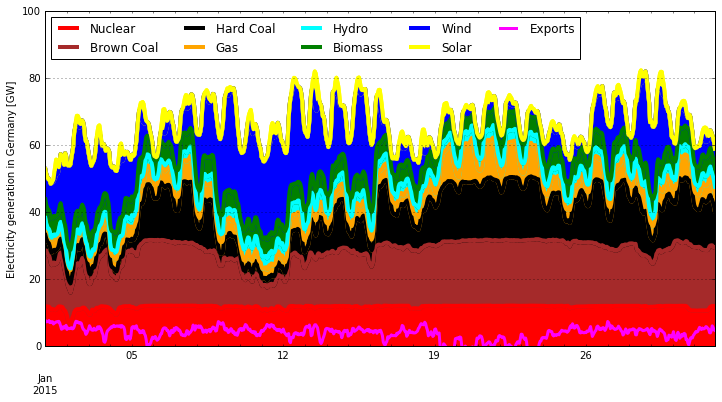

In [25]:
fig,ax = plt.subplots(1,1)

fig.set_size_inches(12,6)

start = "2015-01-01"

stop = "2015-01-31"


colors = {"Brown Coal" : "brown",
          "Hard Coal" : "k",
          "Nuclear" : "r",
          "Hydro" : "cyan",
          "Wind" : "blue",
          "Solar" : "yellow",
          "Biomass" : "green",
          "Waste" : "orange",
          "Gas" : "orange"}
#reorder
cols = ["Nuclear","Brown Coal","Hard Coal","Gas","Hydro","Biomass","Wind","Solar"]

df[cols][start:stop].plot(kind="area",
                         ax=ax,
                         colors=[colors[col] for col in cols],
                         linewidth=4)

ax.set_ylabel("Electricity generation in Germany [GW]")


ax.set_ylim([0,100])

(-df["Imports"][start:stop]).plot(ax=ax,color="magenta",label="Exports",linewidth=3)

ax.legend(loc="upper left",ncol=5)

ax.yaxis.grid(True)

In [64]:
fig.tight_layout()
#fig.savefig("germany_generation.pdf")

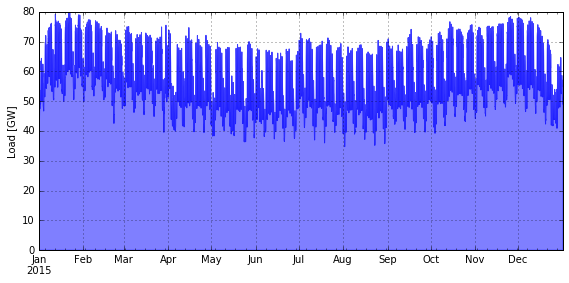

In [44]:
load = df.sum(axis=1)

fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)

ax.set_ylabel("Load [GW]")

load.plot(grid=True,ax=ax,kind='area',alpha=0.5)

fig.tight_layout()

fig.savefig("load-2015.pdf",transparent=True)

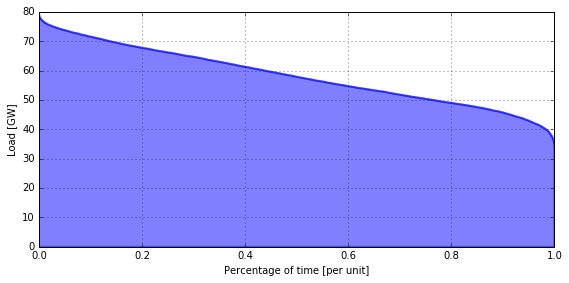

In [43]:
fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)

ax.set_ylabel("Load [GW]")

ax.set_xlabel("Percentage of time [per unit]")

duration_curve(load).plot(grid=True,ax=ax,linewidth=2,kind='area',alpha=0.5)


fig.tight_layout()

fig.savefig("load-duration-2015.pdf",transparent=True)

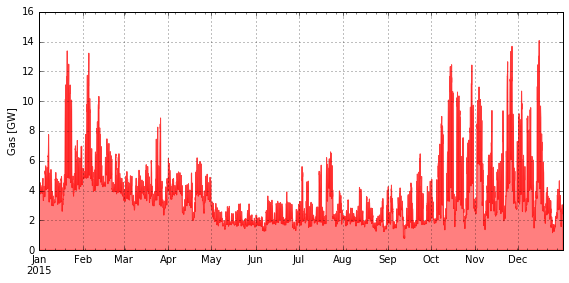

In [53]:
tech = "Gas"

fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)

ax.set_ylabel(tech + " [GW]")

df[tech].plot(grid=True,ax=ax,kind='area',alpha=0.5,color="r")

fig.tight_layout()

fig.savefig(tech + "-2015.pdf",transparent=True)

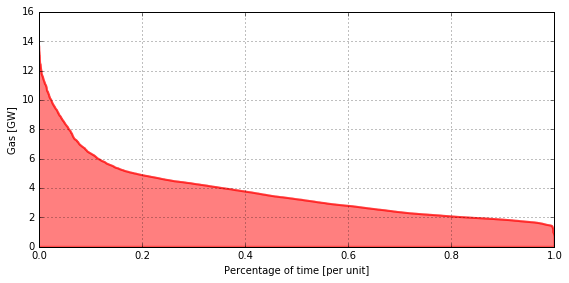

In [54]:
fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)

ax.set_ylabel(tech + " [GW]")

ax.set_xlabel("Percentage of time [per unit]")

duration_curve(df[tech]).plot(grid=True,ax=ax,kind='area',alpha=0.5,color="r",linewidth=2)

fig.tight_layout()

fig.savefig(tech + "-duration-2015.pdf",transparent=True)

# Get electricity price

In [2]:
price_df = pd.read_excel("data/2015_de_spot_price.xls",skiprows=3)

In [3]:
price = pd.Series(price_df[u"€/MWh"].values,pd.date_range("2015-01-01 00:00","2015-12-31 23:00",freq="H"))

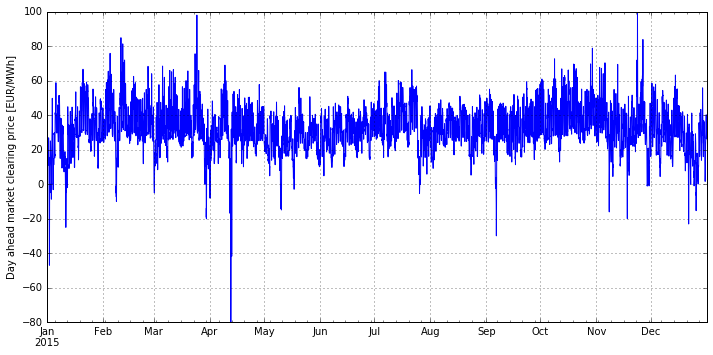

In [55]:
fig,ax = plt.subplots(1,1)

fig.set_size_inches(10,5)

ax.set_ylabel("Day ahead market clearing price [EUR/MWh]")

price.plot(grid=True,ax=ax)

fig.tight_layout()

fig.savefig("price-2015.pdf",transparent=True)

In [7]:
print(price.describe())

count    8760.000000
mean       31.626461
std        12.666900
min       -79.940000
25%        24.920000
50%        30.540000
75%        39.902500
max        99.770000
dtype: float64


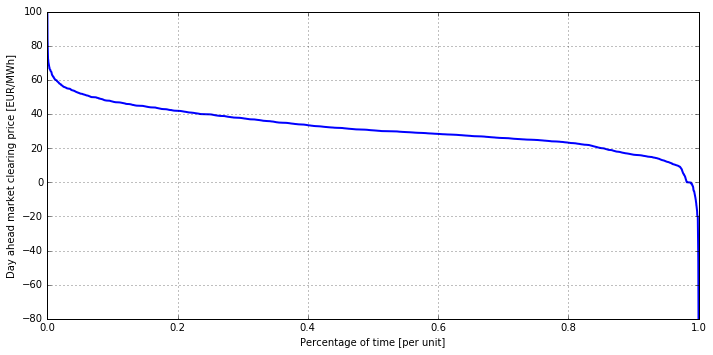

In [57]:
fig,ax = plt.subplots(1,1)

fig.set_size_inches(10,5)

ax.set_ylabel("Day ahead market clearing price [EUR/MWh]")

duration_curve(price).plot(grid=True,ax=ax,linewidth=2)

ax.set_xlabel("Percentage of time [per unit]")

fig.tight_layout()

fig.savefig("price-duration-2015.pdf",transparent=True)

# Plot both together

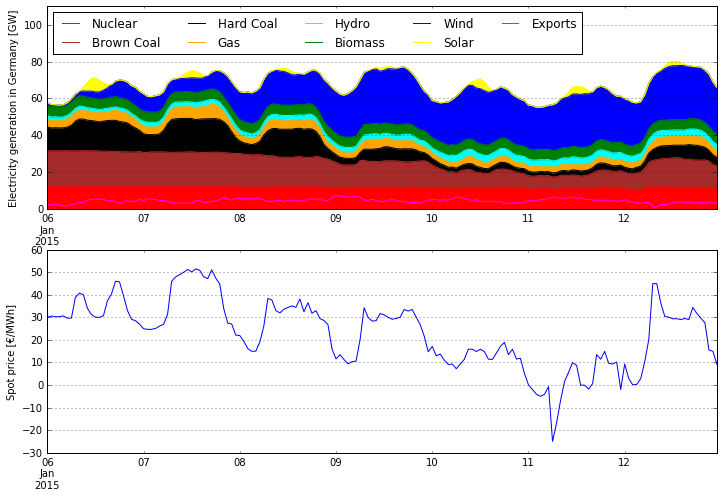

In [132]:
fig,axes = plt.subplots(2,1)

fig.set_size_inches(12,8)

ax = axes[0]

start = "2015-01-06"

stop = "2015-01-12"


colors = {"Brown Coal" : "brown",
          "Hard Coal" : "k",
          "Nuclear" : "r",
          "Hydro" : "cyan",
          "Wind" : "blue",
          "Solar" : "yellow",
          "Biomass" : "green",
          "Waste" : "orange",
          "Gas" : "orange"}
#reorder
cols = ["Nuclear","Brown Coal","Hard Coal","Gas","Hydro","Biomass","Wind","Solar"]

df[cols][start:stop].plot(kind="area",
                         ax=ax,
                         colors=[colors[col] for col in cols],
                         linewidth=1)

ax.set_ylabel("Electricity generation in Germany [GW]")


ax.set_ylim([0,110])

(-df["Imports"][start:stop]).plot(ax=ax,color="magenta",label="Exports",linewidth=1)

ax.legend(loc="upper left",ncol=5)

ax.grid(True)

ax = axes[1]

ax.set_ylabel(u"Spot price [€/MWh]")


price[start:stop].plot(ax=ax)


ax.grid(True)

In [133]:
fig.tight_layout()
fig.savefig("germany_generation-price-{}-{}.pdf".format(start,stop))